**Deep Learning Convolutional Neural Network** </br>

Development of a convolutional network to predict the age of an individual whose face appears in an image using a pretrained model.

Code developed by Marcelo Ferrer and Aymen Merchaoui

The notebook is divided in a similar structure that the one used for the gender prediction:
1. Imports, declarations and configuration
2. Dataset
3. Testing </br>
    Optimizer Selection</br>
    Feature extraction and activation Function Selection</br>
    Feature extraction and fine-tuning selection</br>
    Optimizer Fine-tuning</br>
4. Results</br>

## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

The constants for img_height, img_width and batch_size are defined here.

In the next cell we validate that the GPU is active, as each training for the simple model takes around 25 minutes to run with GPU and without it the time for training is more than one hour each.

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
# imports
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import visualkeras

from os import listdir
import os 
import os.path

import json

In [3]:
# Size at which images will be processed
img_height = 32
img_width = 32

batch_size = 128

# If activated test the optimizers
test_optimizer = False
# If activated test the models
test_models_activation = False
# If activated test the models
test_models_layers = False

Load the paths and verify they exist

In [4]:
# Dataset path
PATH = 'datasets/faces/faces_dataset_train/'
PATH_TEST = 'datasets/faces/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 2. Dataset

In this section we load the dataset for training and validation.
The size of the train set is 126865 rows and the training is 200.

### Metadata access

In [6]:
with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

Count training images: 126865
Count test images: 1000
Image shape:  (32, 32, 3)
Label:  26


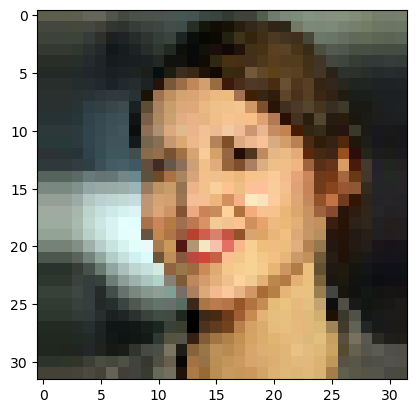

Image shape:  (32, 32, 3)
Label:  78


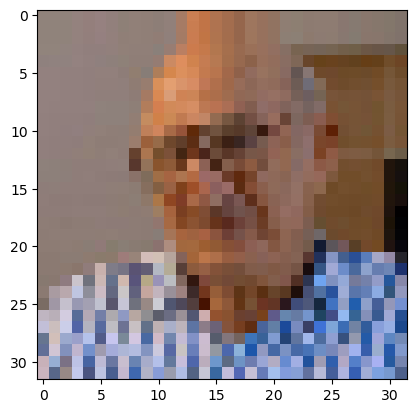

Image shape:  (32, 32, 3)
Label:  28


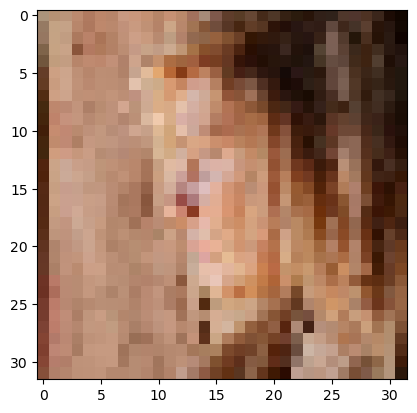

Image shape:  (32, 32, 3)
Label:  32


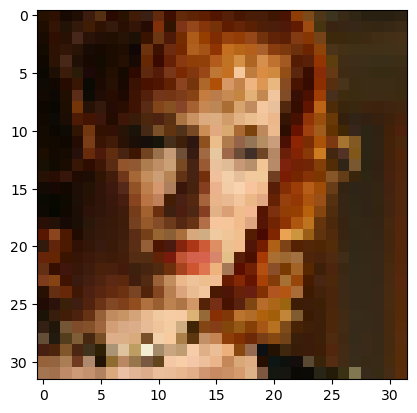

Image shape:  (32, 32, 3)
Label:  66


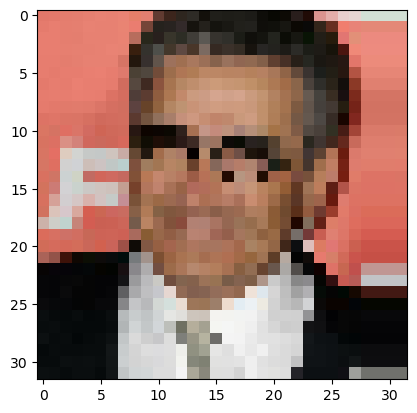

In [7]:
def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

print("Count training images:", len(train_ds))
print("Count test images:",len(test_ds))

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [8]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])
print(train_metadata[1])

datasets/faces/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M
datasets/faces/faces_dataset_train/i47/nm0716347_rm278112000_1970-9-29_2013.jpg|43|M


In [9]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform_rs11 = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform_rs11 = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [10]:
# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform_rs01 = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform_rs01 = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

**Data balance**

As the dataset is a little imbalance (74253 men and 52612 women), a weight strategy could be a good idea. This will assign more weight to the class with less instances so the model will learn with the same influence for both classes.

In [11]:
# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform_we = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform_we = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

tf.Tensor(
[1.76150383 0.08628557 0.01546083 0.01225852 0.01755069 0.03502511
 0.06879879 0.16056922 0.52553153 7.31701591], shape=(10,), dtype=float64)


In [12]:
ds_train_transform_rs11_we = ds_train_transform_rs11.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform_rs11_we = ds_test_transform_rs11.map(lambda image, label: (image, label, sample_weights[label]))

Finally we create batch for all the datasets to be used in testing.

In [13]:
ds_train_batch_or = ds_train_transform.batch(batch_size)
ds_test_batch_or = ds_test_transform.batch(batch_size)

ds_train_batch_rs11 = ds_train_transform_rs11.batch(batch_size)
ds_test_batch_rs11 = ds_test_transform_rs11.batch(batch_size)

ds_train_batch_rs01 = ds_train_transform_rs01.batch(batch_size)
ds_test_batch_rs01 = ds_test_transform_rs01.batch(batch_size)

ds_train_batch_we = ds_train_transform_we.batch(batch_size)
ds_test_batch_we = ds_test_transform_we.batch(batch_size)

ds_train_batch_rs11_we = ds_train_transform_rs11.batch(batch_size)
ds_test_batch_rs11_we = ds_test_transform_rs11.batch(batch_size)

## 3. Testing

In this section we experiment with different models. We use the same datasets, optimizers and models that we use for the gender classification.

### Default configuration

In this subsection we load the default configuration of the application that were defined in previous test of the gender model.

In [14]:
# Function to print the results of the training
def print_plot(name, history):
    # summarize history for train accuracy
    fig, axs = plt.subplots(1,2)
    fig.suptitle(name + ' - Training and validation')
    fig.set_figwidth(10)
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['Loss', 'Val_loss'])
    axs[1].plot(history.history['mean_absolute_error'])
    axs[1].plot(history.history['val_mean_absolute_error'])
    axs[1].set_title('MAE')
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['MAE', 'Val_MAE'])
    plt.savefig('images/' + name + '.png')
    plt.show()

In [15]:
# Get the default optimizer
def get_optimizer():
    return optimizers.Adam(learning_rate=0.01)

In [16]:
# Assign the default dataset. We keep the same that we use in the gender classification
ds_train_batch = ds_train_batch_rs11_we
ds_test_batch = ds_test_batch_rs11_we

# Create call back to use later
# If 20 epochs without improvement in the loss, stop the training
# This is to save computational power as a 20 epoch value without improvement we know is not going to get better
late_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# Reduce the learning rate if we reach a point that the validation loss does not improve more
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.000001, cooldown=2, verbose=1)

# Activation function defined after testing
activation='relu'

In [17]:
def get_new_model(activation, num_layers):
    old_model = load_model("models/best_model.keras")

    new_model = Sequential()
    layers_to_train = num_layers * -1

    count = 0

    for layer in old_model.layers[:-1]:
        layer._name = "Layer_" + str(count)
        new_model.add(layer)

        count = count + 1

    # We add a new regression layer
    # It has a single output neuron and a relu activation
    new_model.add(Dense(1, activation=activation))

    new_model.trainable = True,
    for layer in new_model.layers[:layers_to_train]:
        layer.trainable = False

    return new_model

In [18]:
# Function to get the callbacks for the test of the models
def get_callbacks(name):
    # This is to save computational power as a 15 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=15, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/age/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1)
            ]

In [19]:
# Function to get the callbacks for the test of the models
def get_callbacks_ft(name):
    # This is to save computational power as a 15 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=20, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/age/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=14, min_lr=0.000001, cooldown=1, verbose=1)
            ]

Show the model pretrained in the gender notebook

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                           

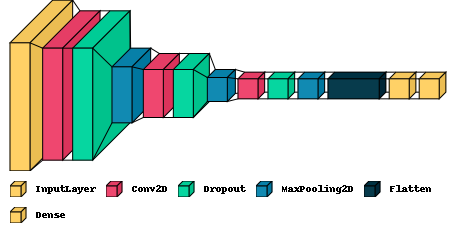

In [20]:
# Load the model
old_model = load_model("models/best_model.keras")
old_model.summary()

visualkeras.layered_view(old_model, legend=True)

### Optimizer selection

In this sub section we determinate which optimizer to use. 

For the selection of the optimizer, we choose the same optimizers as for the gender model: RMSprop, Adam, Adamax and SGD. In this case, we use a higher value for the learning rate, as the models take many epochs to overfit.

Then we execute the simple model and evaluate which one has the better performance after 50 epochs.

In [21]:
if test_optimizer == True:
    opt_names = ["RMSprop","adam","Adamax","SGD"]
    opt_values = [optimizers.RMSprop(learning_rate=0.01),optimizers.Adam(learning_rate=0.01), optimizers.Adamax(learning_rate=0.01),optimizers.SGD(learning_rate=0.01)]
    test_history= []

In [22]:
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        new_model = get_new_model(activation, 1)

        new_model.compile(optimizer=opt_values[i], loss="mse", metrics=["MeanAbsoluteError"])
        print("Testing optimizer:",opt_names[i])
        # No batch size because we did it before
        test_history.append(new_model.fit(ds_train_batch, epochs=50, validation_data=ds_test_batch, callbacks=[late_stop, reduce_lr]))

In [23]:
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        print(opt_names[i], " - MAE:", min(test_history[i].history['val_mean_absolute_error']))
        print_plot(opt_names[i],test_history[i])

![Adam execution](images/age/adam.png)
![Adamax execution](images/age/Adamax.png)
![Rmsprop execution](images/age/Rmsprop.png)

In this case, instead of Adamax that we use for the gender classification, the best optimizer was Adam as it get a better stable curve in the plot. We have a similar result for RMSProp but we decide to go with adam because the curves where a little more plain (less fluctuations).

For future executions of the notebook, we use the variable test_optimizer in false to not repeat this test.

### Feature extraction and activation function selection

In this subsection we test for the best activation function to train our new model

We save the best model to have them as history of execution but we are not going to use them in future tests.

We decide to test two possible activations functions relu and linear as this is now a regression problem.

In [24]:
history = []
names = ['Last_layer_relu','Last_layer_identity']
activations = ['relu', 'linear']

In [25]:
if test_models_activation == True:
    for i in range(0,len(names)):
        # We create a new model with all the layers of the old one except the last one.
        new_model = get_new_model(activations[i], 1)
        new_model.summary()

        # Train the new model (new_model) with the new labels 
        new_model.compile(optimizer=get_optimizer(), loss="mse", metrics=["MeanAbsoluteError"])
        history.append(new_model.fit(ds_train_batch, epochs=100,validation_data=ds_test_batch, callbacks=get_callbacks(names[i])))

In [26]:
if test_models_activation == True:
    for i in range(0,len(names)):
        print(names[i], " - MAE:", min(history[i].history['val_mean_absolute_error']))
        print_plot(names[i],history[i])

![Execution with relu activation function](images/age/last_layer_relu.png)
![Execution with linear activation function](images/age/last_layer_identity.png)

After the execution of the two test for the activation function, we have similar results, so we decide to continue with relu as it take less epochs to reach the same mae that the linear function.

### Feature extraction and fine-tuning selection

In this subsection we replace the classification and test unfreezing different amount layers using the decisions we made in the previous sub sections.

We create an array with the layer we want to unfreeze to execute it in a loop. We decide to try with the classification layer, the fully conected layer and the first of the three convolutional layers. We stop there as we think adding more layer to the trainable param will loose the point of using the pre trained function from the gender classification.

As before, the images and models of the execution are stored in the folders.

In [27]:
history = []
best_mae = []
names = ['layer_1','layer_2','layer_6']
num_layers = [1,2,6]

In [32]:
if test_models_layers == True:
    for i in range(0,len(names)):

        # We create a new model with all the layers of the old one except the last one.
        new_model = get_new_model(activation, num_layers[i])

        new_model.summary()

        new_model.compile(optimizer=get_optimizer(), loss="mse", metrics=["MeanAbsoluteError"])
        history.append(new_model.fit(ds_train_batch, epochs=100,validation_data=ds_test_batch, callbacks=get_callbacks(names[i])))

In [31]:
if test_models_layers == True:
    for i in range(0,len(names)):
        print(names[i], " - MAE:", min(history[i].history['val_mean_absolute_error']))
        print_plot(names[i],history[i])
        best_mae.append(min(history[i].history['val_mean_absolute_error']))

![Execution with only the first layer trainable](images/age/layer_1.png)
![Execution with only the first two layers trainables](images/age/layer_2.png)
![Execution with only the first six layers trainables](images/age/layer_6.png)

As we can see in the graph above, the layer_2 model start overfitting, with the layer_1 and the layer_2 keep improving. The best metrics are the ones we got from the unfreezing of the 6 layers, that include the activation, the fully conected layer and the last convolutional layer. So, for the final section of the notebook, we will do the optimizer fine-tuning on this model structure.

For future executions of the notebook, we use the variable test_models_layers in false to not repeat this test.

### Optimizer Fine-tuning

In this section we do the optimizer fine tuning of the best model. After experimenting with different models and selecting the best, we train the model with a optimizer learning rate and iterate with lower values, so it gets the best possible loss. For this we use the ReduceLROnPlateau of keras that reduce the learning rate if a determinated number of epochs have not improve in the loss.

In [30]:
# We create a new model with the best testing results
new_model = get_new_model(activation, 6)

new_model.summary()
visualkeras.layered_view(new_model, legend=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv2D)            (None, 28, 28, 32)        2432      
                                                                 
 Layer_2 (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 Layer_3 (MaxPooling2D)      (None, 14, 14, 32)        0         
                                                                 
 Layer_4 (Conv2D)            (None, 12, 12, 64)        18496     
                                                                 
 Layer_5 (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 Layer_6 (MaxPooling2D)      (None, 6, 6, 64)          0         
                                                                 
 Layer_7 (Conv2D)            (None, 4, 4, 128)         7

In [31]:
# Fine-tuning the model
new_model.compile(optimizer=get_optimizer(), loss="mse", metrics=["MeanAbsoluteError"])
hist = new_model.fit(ds_train_batch, epochs=200,validation_data=ds_test_batch, callbacks=get_callbacks_ft('age_final_model'))

Epoch 1/200
992/992 [==============================] - ETA: 0s - loss: 168.3633 - mean_absolute_error: 10.0508
Epoch 1: val_loss improved from inf to 1215.64734, saving model to models/age\age_final_model.keras
992/992 [==============================] - 23s 17ms/step - loss: 168.3633 - mean_absolute_error: 10.0508 - val_loss: 1215.6473 - val_mean_absolute_error: 28.4368 - lr: 0.0100
Epoch 2/200
991/992 [============================>.] - ETA: 0s - loss: 152.9395 - mean_absolute_error: 9.5648
Epoch 2: val_loss improved from 1215.64734 to 1213.49365, saving model to models/age\age_final_model.keras
992/992 [==============================] - 17s 17ms/step - loss: 152.9401 - mean_absolute_error: 9.5648 - val_loss: 1213.4937 - val_mean_absolute_error: 28.4009 - lr: 0.0100
Epoch 3/200
991/992 [============================>.] - ETA: 0s - loss: 150.3797 - mean_absolute_error: 9.4482
Epoch 3: val_loss improved from 1213.49365 to 1064.30298, saving model to models/age\age_final_model.keras
992/99

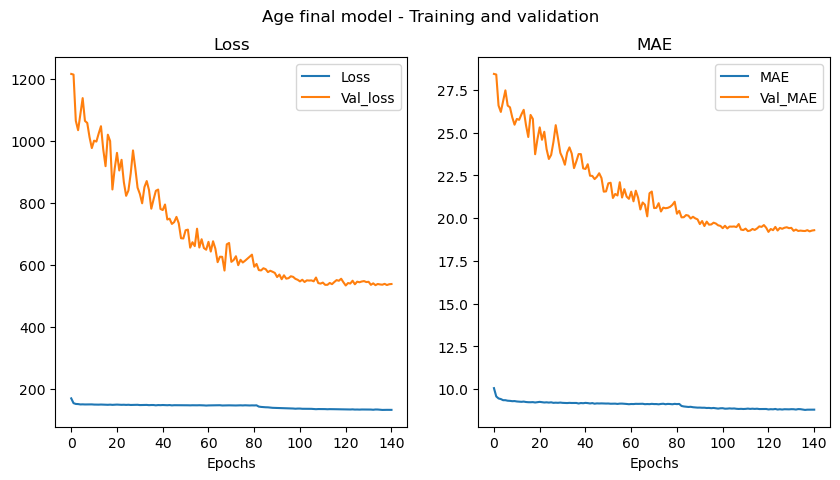

Epoch: 121 - Model MAE: 19.193761825561523 - Best MAE: 19.193761825561523


In [32]:
print_plot("Age final model", hist)
min_loss = min(hist.history['val_loss'])
epoch = 0

for x in range(0, len(hist.history['val_loss'])):
    if hist.history['val_loss'][x] == min_loss:
        epoch = x + 1
        acc = hist.history['val_mean_absolute_error'][x]

print("Epoch:", epoch, "- Model MAE:", acc, "- Best MAE:", min(hist.history['val_mean_absolute_error']))

As we can see in the above code and graph, we try to get the best possible weights for the model that we select to be the final one. 

We started the tunning with a 0.01 value of learning rate and finish with a 0.0001. In the graph and log of the training we can observe that at first has the more pronounced curves as the model is been training with the highest values. Then with each change in the learning rate, the curve start to get more linear, till reach the end where no improvement is made.

For future executions of the notebook this sub section is going to keep been executed, as is the final execution of our model.

## 4. Results

In this section we show the final results

One layer - MAE: 24.03
Six layers - MAE: 20.47
Six layers finetuning - MAE: 19.19


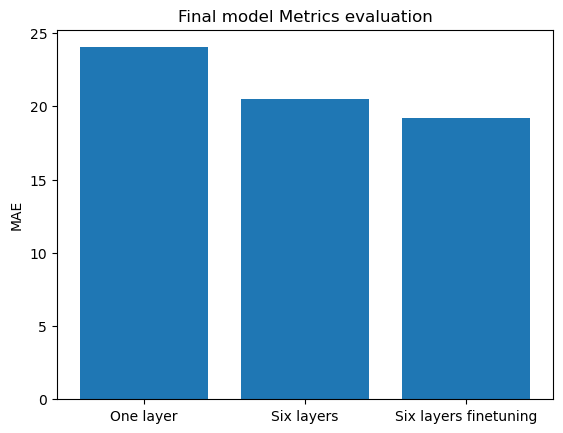

In [30]:
mae_models = [24.03, 20.47, 19.19]
mae_names = ["One layer", "Six layers", "Six layers finetuning"]

for i in range(0,len(mae_names)):
    print(mae_names[i], '- MAE:', mae_models[i])

plt.bar(mae_names,mae_models)
plt.title('Final model Metrics evaluation')
plt.ylabel('MAE')
plt.show()

In the above graphic we can see the evolution of our model thought the three steps that we set for our selection, first the test with the pretrained model only replacing the classification layer, then the test replacing the classification layer and unfreezing the fully connected layer and the first convolutional layer and finally the fine tunning of that model.

As we mention before, better validation mae metrics have been obtained, but we decide to use the ones that correspond to the lowest loss value. In the final execution of our model, the validation mae was 87.32.